In [1]:
import sys
sys.path.append(r'f:\GraduateStudent')

from Projects.Utils.Data_Train import Utils_Trainer, Utils_DatasetFactory
from Projects.Model.NN import LSTM
import Projects.Utils.tools as tools
from Projects.Model.Function import Sigmoid, TanH

tools.utils_setSeed(42)

f:\GraduateStudent\Projects\Utils\config.json


Epoch 0, Loss: 0.5038
Epoch 10, Loss: 0.0219
Epoch 20, Loss: 0.0154
Epoch 30, Loss: 0.0121
Epoch 40, Loss: 0.0099
Epoch 50, Loss: 0.0082
Epoch 60, Loss: 0.0066
Epoch 70, Loss: 0.0050
Epoch 80, Loss: 0.0032
Epoch 90, Loss: 0.0016


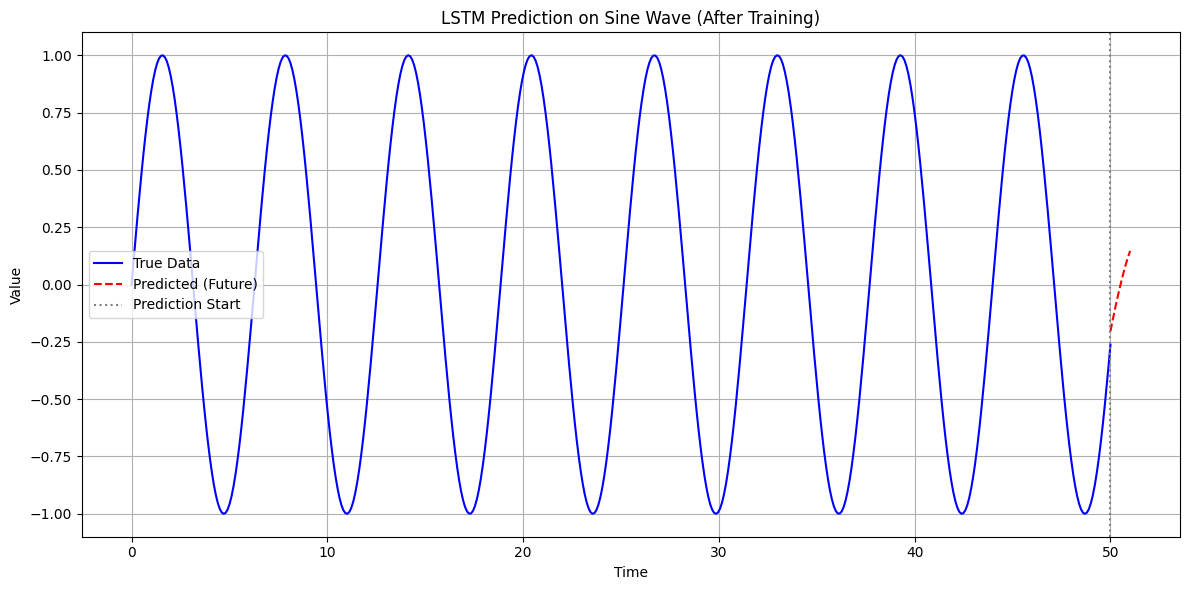

Last 5 true values: [-0.61806907 -0.53633075 -0.4492121  -0.35758709 -0.26237485]
First 5 predictions: [-0.20373588444259544, -0.15617296646103856, -0.11042999102547751, -0.06659625009325651, -0.024806405997226125]


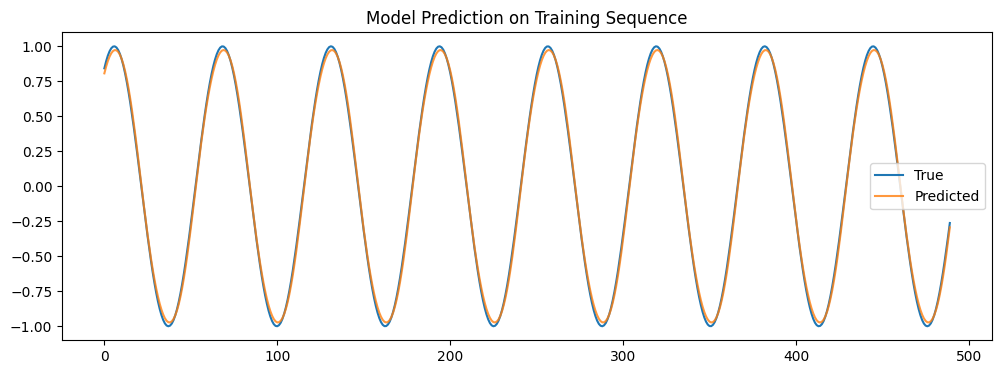

In [ ]:
import numpy as np

sigmoid = Sigmoid()
tanh = TanH()

class Manual_LSTM:
  def __init__(self, input_size, hidden_size, output_size, lr=0.01):
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.lr = lr

    self.wf = np.random.randn(hidden_size, input_size+hidden_size)*.01
    self.bf = np.zeros((hidden_size, 1))
    self.wi = np.random.randn(hidden_size, input_size+hidden_size)*.01
    self.bi = np.zeros((hidden_size, 1))
    self.wc = np.random.randn(hidden_size, input_size+hidden_size)*.01
    self.bc = np.zeros((hidden_size, 1))
    self.wo = np.random.randn(hidden_size, input_size+hidden_size)*.01
    self.bo = np.zeros((hidden_size, 1))
    self.wy = np.random.randn(output_size, hidden_size)*.01
    self.by = np.zeros((output_size, 1))
    self.gradients = {}

  def forward(self, x, h_prev, c_prev):
    concat = np.vstack((h_prev, x))
    ft = sigmoid(np.dot(self.wf, concat)+self.bf)
    it = sigmoid(np.dot(self.wi, concat)+self.bi)
    c_hat = tanh(np.dot(self.wc, concat)+self.bc)
    c = ft*c_prev+it*c_hat
    ot = sigmoid(np.dot(self.wo, concat)+self.bo)
    h = ot*tanh(c)
    y = np.dot(self.wy, h)+self.by
    cache = (x, h_prev, c_prev, concat, ft, it, c_hat, c, ot, h)
    return h, c, y, cache
  
  def backward(self, dy, cache, dh_next=None, dc_next=None):
    x, h_prev, c_prev, concat, ft, it, c_hat, c, ot, h = cache
    dwy = np.dot(dy, h.T)
    dby = dy
    dh = np.dot(self.wy.T, dy)
    if dh_next is not None:
      dh += dh_next

    dot = dh*tanh(c)
    dot = dot*ot*(1-ot)
    dc = dh*ot*(1-tanh(c)**2)
    if dc_next is not None:
      dc += dc_next
    
    dc_hat = dc*it
    dc_hat = dc_hat*(1-c_hat**2)
    dit = dc*c_hat
    dit = dit*it*(1-it)

    dft = dc*c_prev
    dft = dft*ft*(1-ft)

    dconcat = (
      np.dot(self.wf.T, dft)+
      np.dot(self.wi.T, dit)+
      np.dot(self.wc.T, dc_hat)+
      np.dot(self.wo.T, dot)
    )
    dh_prev = dconcat[:self.hidden_size, :]
    dx = dconcat[self.hidden_size:, :]
    dc_prev = dc*ft
    self.gradients['dwf'] += np.dot(dft, concat.T) # dc*c_prev*ft*(1-ft)@concat.T
    self.gradients['dbf'] += dft
    self.gradients['dwi'] += np.dot(dit, concat.T)
    self.gradients['dbi'] += dit
    self.gradients['dwc'] += np.dot(dc_hat, concat.T)
    self.gradients['dbc'] += dc_hat
    self.gradients['dwo'] += np.dot(dot, concat.T)
    self.gradients['dbo'] += dot
    self.gradients['dwy'] += dwy
    self.gradients['dby'] += dby

    return dh_prev, dc_prev
  
  def update_parameters(self):
    self.wf -= self.lr*self.gradients['dwf']
    self.bf -= self.lr*self.gradients['dbf']
    
    self.wi -= self.lr*self.gradients['dwi']
    self.bi -= self.lr*self.gradients['dbi']
    
    self.wc -= self.lr*self.gradients['dwc']
    self.bc -= self.lr*self.gradients['dbc']
    
    self.wo -= self.lr*self.gradients['dwo']
    self.bo -= self.lr*self.gradients['dbo']
    
    self.wy -= self.lr*self.gradients['dwy']
    self.by -= self.lr*self.gradients['dby']

  def zero_gradients(self):
    self.gradients = {
      'dwf': np.zeros_like(self.wf),
      'dbf': np.zeros_like(self.bf),
      'dwi': np.zeros_like(self.wi),
      'dbi': np.zeros_like(self.bi),
      'dwc': np.zeros_like(self.wc),
      'dbc': np.zeros_like(self.bc),
      'dwo': np.zeros_like(self.wo),
      'dbo': np.zeros_like(self.bo),
      'dwy': np.zeros_like(self.wy),
      'dby': np.zeros_like(self.by),
    }

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# 示例数据：正弦波
t = np.linspace(0, 50, 500)
# data = np.sin(t) + 0.1 * np.random.randn(500)
data = np.sin(t)
data = data.reshape(-1, 1)  # (500, 1)

seq_length = 10
X, y = create_sequences(data, seq_length)  # X: (490, 10, 1), y: (490, 1)

model = Manual_LSTM(
    input_size=1,
    hidden_size=10,
    output_size=1,
    lr=0.005
)

epochs = 100
for epoch in range(epochs):
    total_loss = 0
    for i in range(len(X)):
        # 初始化隐藏状态
        model.zero_gradients()
        h = np.zeros((model.hidden_size, 1))
        c = np.zeros((model.hidden_size, 1))
        caches = []
        outputs = []

        # 前向传播（整个序列）
        for t_step in range(seq_length):
            x_t = X[i, t_step].reshape(-1, 1)  # (1, 1)
            h, c, y_pred, cache = model.forward(x_t, h, c)
            outputs.append(y_pred)
            caches.append(cache)
        
        # 计算损失（只预测最后一步）
        y_true = y[i].reshape(-1, 1)  # (1, 1)
        loss = np.mean((outputs[-1] - y_true) ** 2)
        total_loss += loss

        # 反向传播（从最后一个时间步开始）
        dy = 2 * (outputs[-1] - y_true)  # MSE 梯度
        dh_next, dc_next = None, None
        for t_step in reversed(range(seq_length)):
            dh_next, dc_next = model.backward(
                dy if t_step == seq_length - 1 else np.zeros_like(outputs[t_step]),
                caches[t_step],
                dh_next,
                dc_next
            )
            dy = np.zeros_like(outputs[t_step])  # 除最后一步外，dy=0

        model.update_parameters()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss/len(X):.4f}")

# ----------------------------
# 测试：用训练好的模型预测未来值
# ----------------------------

import matplotlib.pyplot as plt

# 使用最后 seq_length 个点作为初始输入（来自原始数据）
test_input = data[-seq_length:].reshape(1, seq_length, 1)  # shape: (1, 10, 1)

# 初始化隐藏状态
h_test = np.zeros((model.hidden_size, 1))
c_test = np.zeros((model.hidden_size, 1))

# 预测未来 n_future 步
n_future = 10
predicted = []

# 先用 test_input 跑一遍前向（不保存输出，只获取最终 h, c）
for t_step in range(seq_length):
    x_t = test_input[0, t_step].reshape(-1, 1)
    h_test, c_test, _, _ = model.forward(x_t, h_test, c_test)

# 现在开始预测未来
last_x = test_input[0, -1].reshape(-1, 1)  # 最后一个真实值作为起点
for _ in range(n_future):
    h_test, c_test, y_pred, _ = model.forward(last_x, h_test, c_test)
    predicted.append(y_pred.item())  # scalar
    last_x = y_pred  # 用预测值作为下一步输入（自回归）

# 构建时间轴
t_full = np.linspace(0, 50, 500)
t_future = np.linspace(50, 50 + (n_future * (50/499)), n_future)  # 近似等距

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(t_full, data.flatten(), label='True Data', color='blue')
plt.plot(t_future, predicted, label='Predicted (Future)', color='red', linestyle='--')
plt.axvline(x=50, color='gray', linestyle=':', label='Prediction Start')
plt.title('LSTM Prediction on Sine Wave (After Training)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 打印最后几个预测值
print("Last 5 true values:", data[-5:].flatten())
print("First 5 predictions:", predicted[:5])

# 在训练集上做 inference（非未来预测）
h_eval = np.zeros((model.hidden_size, 1))
c_eval = np.zeros((model.hidden_size, 1))
eval_preds = []

for i in range(len(X)):
    h_eval = np.zeros((model.hidden_size, 1))
    c_eval = np.zeros((model.hidden_size, 1))
    for t_step in range(seq_length):
        x_t = X[i, t_step].reshape(-1, 1)
        h_eval, c_eval, y_pred, _ = model.forward(x_t, h_eval, c_eval)
    eval_preds.append(y_pred.item())

# 绘制训练集预测 vs 真实
plt.figure(figsize=(12, 4))
plt.plot(y[:len(eval_preds)], label='True')
plt.plot(eval_preds, label='Predicted', alpha=0.8)
plt.title('Model Prediction on Training Sequence')
plt.legend()
plt.show()

## LSTM实例
- 航班客流量预测

Using device: cuda
train&evaluate: 1/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 226.01batch/s]


evaluation:  0.3774674932161967
train&evaluate: 2/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 225.05batch/s]


evaluation:  0.2675768236319224
train&evaluate: 3/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 270.04batch/s]


evaluation:  0.06316660717129707
train&evaluate: 4/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1089.71batch/s]


evaluation:  0.04099240526556969
train&evaluate: 5/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1192.02batch/s]


evaluation:  0.041663799434900284
train&evaluate: 6/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 859.37batch/s]


evaluation:  0.11348512768745422
train&evaluate: 7/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1130.74batch/s]


evaluation:  0.07981414347887039
train&evaluate: 8/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 983.12batch/s]


evaluation:  0.03169119295974573
train&evaluate: 9/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1067.80batch/s]


evaluation:  0.06475096195936203
train&evaluate: 10/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 893.42batch/s]


evaluation:  0.05700655902425448
train&evaluate: 11/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 878.02batch/s]


evaluation:  0.0369319257636865
train&evaluate: 12/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 957.53batch/s]


evaluation:  0.02569127393265565
train&evaluate: 13/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1140.89batch/s]


evaluation:  0.039905709524949394
train&evaluate: 14/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 948.37batch/s]


evaluation:  0.06591727460424106
train&evaluate: 15/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1012.38batch/s]


evaluation:  0.02168421633541584
train&evaluate: 16/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 674.04batch/s]


evaluation:  0.022042954961458843
train&evaluate: 17/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 890.32batch/s]


evaluation:  0.018089027764896553
train&evaluate: 18/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 895.07batch/s]


evaluation:  0.013479468412697315
train&evaluate: 19/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1077.21batch/s]


evaluation:  0.028130071237683296
train&evaluate: 20/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 872.48batch/s]


evaluation:  0.045082482819755874
train&evaluate: 21/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1027.76batch/s]


evaluation:  0.014288000452021757
train&evaluate: 22/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1220.58batch/s]


evaluation:  0.02237348072230816
train&evaluate: 23/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 988.29batch/s]


evaluation:  0.021630116427938145
train&evaluate: 24/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1030.54batch/s]


evaluation:  0.02024849783629179
train&evaluate: 25/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1108.04batch/s]


evaluation:  0.04778756760060787
train&evaluate: 26/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1044.92batch/s]


evaluation:  0.016430293520291645
train&evaluate: 27/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1074.54batch/s]


evaluation:  0.019572859319547813
train&evaluate: 28/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1067.16batch/s]


evaluation:  0.013317393759886423
train&evaluate: 29/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 974.89batch/s]


evaluation:  0.012410080060362816
train&evaluate: 30/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 651.42batch/s]


evaluation:  0.013760719448328018
train&evaluate: 31/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1102.02batch/s]


evaluation:  0.021195062746604282
train&evaluate: 32/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1068.88batch/s]


evaluation:  0.03006185156603654
train&evaluate: 33/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1116.89batch/s]


evaluation:  0.017474584902326267
train&evaluate: 34/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1164.98batch/s]


evaluation:  0.01575005054473877
train&evaluate: 35/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1065.99batch/s]


evaluation:  0.017616312950849533
train&evaluate: 36/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 959.72batch/s]


evaluation:  0.0166419039790829
train&evaluate: 37/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1117.09batch/s]


evaluation:  0.02330932952463627
train&evaluate: 38/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 962.36batch/s]


evaluation:  0.019653160125017166
train&evaluate: 39/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1077.95batch/s]


evaluation:  0.020039139936367672
train&evaluate: 40/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 906.35batch/s]


evaluation:  0.018753796194990475
train&evaluate: 41/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1124.88batch/s]


evaluation:  0.019595551925400894
train&evaluate: 42/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1008.73batch/s]


evaluation:  0.01845805129657189
train&evaluate: 43/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1059.61batch/s]


evaluation:  0.02188022496799628
train&evaluate: 44/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1124.48batch/s]


evaluation:  0.03220922934512297
train&evaluate: 45/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1059.44batch/s]


evaluation:  0.02350949899603923
train&evaluate: 46/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 991.33batch/s]


evaluation:  0.02150331934293111
train&evaluate: 47/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1014.34batch/s]


evaluation:  0.024265970413883526
train&evaluate: 48/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1091.41batch/s]


evaluation:  0.024411911455293495
train&evaluate: 49/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1099.04batch/s]


evaluation:  0.028239950848122437
train&evaluate: 50/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1055.70batch/s]


evaluation:  0.023125508800148964
train&evaluate: 51/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1032.91batch/s]


evaluation:  0.02628433300803105
train&evaluate: 52/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1012.87batch/s]


evaluation:  0.02721481615056594
train&evaluate: 53/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1078.87batch/s]


evaluation:  0.02530507588138183
train&evaluate: 54/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 993.60batch/s]


evaluation:  0.03478685145576795
train&evaluate: 55/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1166.16batch/s]


evaluation:  0.03615202195942402
train&evaluate: 56/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 929.18batch/s]


evaluation:  0.019380023702979088
train&evaluate: 57/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1165.52batch/s]


evaluation:  0.02167472367485364
train&evaluate: 58/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 699.13batch/s]


evaluation:  0.031490701561172806
train&evaluate: 59/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 962.73batch/s]


evaluation:  0.028952883556485176
train&evaluate: 60/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 998.17batch/s]


evaluation:  0.02565796176592509
train&evaluate: 61/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1069.07batch/s]


evaluation:  0.024543396818141144
train&evaluate: 62/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1070.98batch/s]


evaluation:  0.024219879259665806
train&evaluate: 63/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1097.99batch/s]


evaluation:  0.026555681601166725
train&evaluate: 64/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1112.84batch/s]


evaluation:  0.025499051436781883
train&evaluate: 65/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 865.16batch/s]


evaluation:  0.024994993582367897
train&evaluate: 66/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 785.94batch/s]


evaluation:  0.023660156565407913
train&evaluate: 67/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 813.38batch/s]


evaluation:  0.02713107628126939
train&evaluate: 68/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 812.95batch/s]


evaluation:  0.02799700542042653
train&evaluate: 69/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 916.65batch/s]


evaluation:  0.02765338433285554
train&evaluate: 70/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 790.04batch/s]


evaluation:  0.02453944676866134
train&evaluate: 71/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 951.02batch/s]


evaluation:  0.025396154262125492
train&evaluate: 72/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 737.09batch/s]


evaluation:  0.026865460289021332
train&evaluate: 73/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 678.25batch/s]


evaluation:  0.027708675091465313
train&evaluate: 74/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 967.77batch/s]


evaluation:  0.028357053486009438
train&evaluate: 75/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 903.88batch/s]


evaluation:  0.028647784143686295
train&evaluate: 76/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 884.56batch/s]


evaluation:  0.02880486100912094
train&evaluate: 77/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 658.24batch/s]


evaluation:  0.02963918447494507
train&evaluate: 78/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 755.64batch/s]


evaluation:  0.03137004002928734
train&evaluate: 79/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 973.16batch/s]


evaluation:  0.029911234974861145
train&evaluate: 80/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 964.43batch/s]


evaluation:  0.027038779109716415
train&evaluate: 81/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 778.74batch/s]


evaluation:  0.026890442396203678
train&evaluate: 82/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 853.77batch/s]


evaluation:  0.02672936363766591
train&evaluate: 83/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 758.69batch/s]


evaluation:  0.027533913341661293
train&evaluate: 84/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 954.26batch/s]


evaluation:  0.028698379173874855
train&evaluate: 85/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 980.05batch/s]


evaluation:  0.02804625779390335
train&evaluate: 86/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 962.44batch/s]


evaluation:  0.02759988947461049
train&evaluate: 87/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 718.90batch/s]


evaluation:  0.028040680413444836
train&evaluate: 88/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1009.22batch/s]


evaluation:  0.028273558244109154
train&evaluate: 89/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 690.57batch/s]


evaluation:  0.028555458411574364
train&evaluate: 90/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1061.40batch/s]


evaluation:  0.027389630985756714
train&evaluate: 91/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 654.07batch/s]


evaluation:  0.026789483924706776
train&evaluate: 92/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 869.71batch/s]


evaluation:  0.02613670937716961
train&evaluate: 93/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 962.81batch/s]


evaluation:  0.02526463009417057
train&evaluate: 94/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 797.75batch/s]


evaluation:  0.025104100505510967
train&evaluate: 95/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 851.58batch/s]


evaluation:  0.024825872853398323
train&evaluate: 96/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 716.28batch/s]


evaluation:  0.02429883771886428
train&evaluate: 97/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 1024.67batch/s]


evaluation:  0.024668612827857334
train&evaluate: 98/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 494.30batch/s]


evaluation:  0.02551778716345628
train&evaluate: 99/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 726.87batch/s]


evaluation:  0.025552219711244106
train&evaluate: 100/100


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 741.79batch/s]


evaluation:  0.025018731442590553


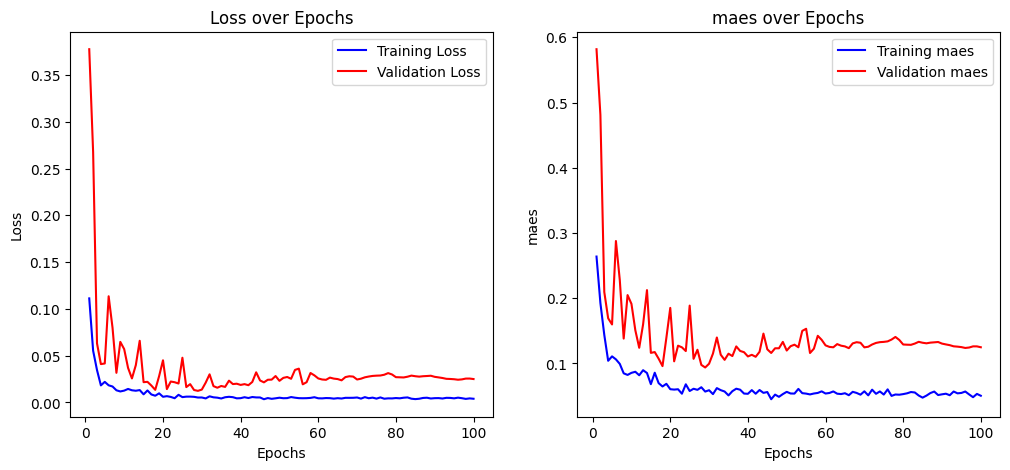

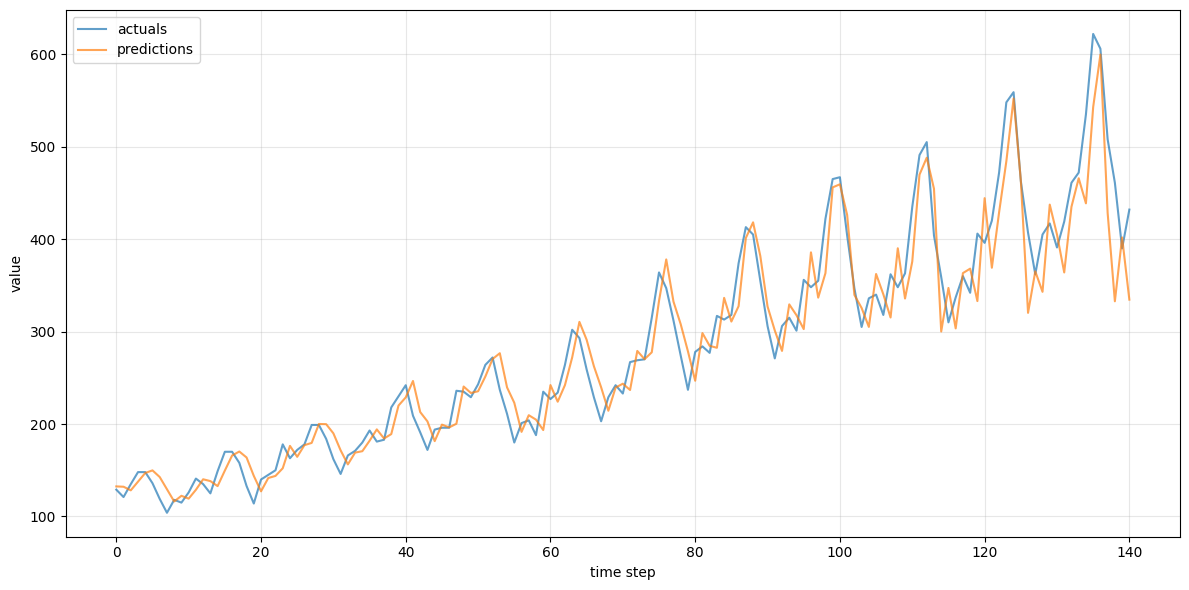

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

device = tools.utils_getDevice()

class MyDataset(Utils_DatasetFactory):
  def __init__(self, csv_path, lookback, train_ratio, batch_size, shuffle, num_workers):
    super().__init__()
    self.lookback = lookback
    self.scaler = MinMaxScaler(feature_range=(0, 1))
    self.load_data(csv_path, train_ratio)
    self.divide_data()
    self.get_dataloader(batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

  def load_rawData(self, csv_path):
    df = pd.read_csv(csv_path, encoding='utf-8')
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    value_col = [col for col in df.columns if col != 'date'][0]
    self.raw_data = df[value_col].values

  def divide_rawData(self, train_ratio=0.8):
    train_size = int(len(self.raw_data)*train_ratio)
    self.train_data_raw = self.raw_data[:train_size]
    self.test_data_raw = self.raw_data[train_size:]

  def scale(self):
    self.scaler = MinMaxScaler(feature_range=(0, 1))
    self.train_scaled = self.scaler.fit_transform(
      self.train_data_raw.reshape(-1, 1)
    ).flatten()
    self.test_scaled = self.scaler.transform(
      self.test_data_raw.reshape(-1, 1)
    ).flatten()
    self.all_scaled = np.concatenate([self.train_scaled, self.test_scaled])

  def load_data(self, csv_path, train_ratio):
    self.load_rawData(csv_path)
    self.divide_rawData(train_ratio)
    self.scale()
    for i in range(self.lookback, len(self.all_scaled)):
      self.X.append(self.all_scaled[i-self.lookback: i])
      self.y.append(self.all_scaled[i])
    self.X, self.y = np.array(self.X), np.array(self.y)

  def divide_data(self):
    seq_train_size = len(self.train_scaled)-self.lookback
    self.train_X, self.eval_X = self.X[:seq_train_size], self.X[seq_train_size:]
    self.train_y, self.eval_y = self.y[:seq_train_size], self.y[seq_train_size:]

  def get_dataloader(self, batch_size=32, shuffle=True, num_workers=0):
    train_loader, eval_loader = super().get_dataloader(batch_size, shuffle, num_workers)
    pred_dataset = TensorDataset(
      torch.tensor(self.X, dtype=torch.float32).unsqueeze(-1),
      torch.tensor(self.y, dtype=torch.float32)
    )
    self.pred_loader = DataLoader(pred_dataset, batch_size, False, num_workers=num_workers)
    return train_loader, eval_loader, self.pred_loader
  
class MyTrainer(Utils_Trainer):
  def __init__(self, model, criterion, optimizer, scheduler = None):
    super().__init__(model, criterion, optimizer, scheduler)

  def train_epoch(self):
    losses, maes = [], []
    pbar = tqdm(self.train_dataloader, desc='Training', unit='batch')
    for i, (batch_X, batch_y) in enumerate(pbar):
      batch_X, batch_y = batch_X.to(device), batch_y.to(device)
      self.optimizer.zero_grad()
      outputs = self.model(batch_X)
      loss = self.criterion(outputs, batch_y)
      loss.backward()
      self.optimizer.step()
      mae = torch.mean(torch.abs(outputs-batch_y))
      losses.append(loss.item())
      maes.append(mae.item())
    return losses, maes
  
  def evaluate_epoch(self):
    losses, maes = [], []
    pbar = tqdm(self.evaluate_dataloader, desc='Evaluating', unit='batch')
    with torch.no_grad():
      for i, (batch_X, batch_y) in enumerate(pbar):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = self.model(batch_X)
        loss = self.criterion(outputs, batch_y)
        mae = torch.mean(torch.abs(outputs-batch_y))
        losses.append(loss.item())
        maes.append(mae.item())
    print('evaluation: ', np.mean(losses))
    return losses, maes
  
  def predict(self, dataloader):
    self.model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
      for batch_X, batch_y in dataloader:
        batch_X = batch_X.to(device)
        outputs = self.model(batch_X)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(batch_y.numpy())
    return np.array(predictions).flatten(), np.array(actuals).flatten()

csv_path = r'f:\GraduateStudent\Data\Airline_Passengers\cleaned_airline_passengers.csv'
model = LSTM(input_size=1, hidden_size=128, num_layers=2, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.3)

data = MyDataset(csv_path, 3, 0.8, 12, True, 0)
trainer = MyTrainer(model, criterion, optimizer, scheduler)
train_losses, train_maes, eval_losses, eval_maes = trainer.train_eval(100,
                                                                      data.train_loader,
                                                                      data.eval_loader)
trainer.plot(train_losses, train_maes, eval_losses, eval_maes, T2='maes')

predictions, actuals = trainer.predict(data.pred_loader)
predictions = data.scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals = data.scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()

# 绘制预测结果
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='actuals', alpha=0.7)
plt.plot(predictions, label='predictions', alpha=0.7)
plt.xlabel('time step')
plt.ylabel('value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


思考🤔：  
  输入门的“水流阀门”（sigmoid部分）一定是h+x吗？  
  ![alt text](微信图片_20251031190736_120_3-1.jpg)  

  可不可以引入第三条“线” ———— 仓库线？  
    负责存储全部记忆 使用h添加记忆 使用c输出记忆  

  End-to-End Memory Networks 能不能当作输出门？